In [1]:
#python connect sql
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import pandas as pd
import json
import os

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host = db_conn_dict['host']
        db_user = db_conn_dict['user']
        db_pw = db_conn_dict['password']
        default_db = db_conn_dict['database']
    try:
        db = create_engine('postgresql+psycopg2://' + db_user + ':' + db_pw + '@' + host + '/' + default_db, echo=False)
        conn = db.connect()
        conn.autocommit = True
        print('Connected successfully.')
    except Exception as e:
        print("Unable to connect to the database.")
        print(e)
        db, conn = None, None
    return db, conn
def query(conn, sql):
    return pd.read_sql(sql, conn)

db, conn = pgconnect(credentials)

Connected successfully.


In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import numpy as np

srid = 4326
SA2 = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
SA2 = SA2[SA2['GCC_NAME21'] == 'Greater Sydney']

def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

SA2['geometry_wkt'] = SA2['geometry'].apply(lambda x: create_wkt_element(x, srid=srid))
SA2 = SA2.drop(columns=['GCC_CODE21', 'GCC_NAME21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'geometry'])


In [3]:
SA2.dtypes

SA2_CODE21       object
SA2_NAME21       object
CHG_FLAG21       object
CHG_LBL21        object
SA3_CODE21       object
SA3_NAME21       object
SA4_CODE21       object
SA4_NAME21       object
AREASQKM21      float64
LOCI_URI21       object
geometry_wkt     object
dtype: object

In [4]:
conn.execute("""CREATE EXTENSION IF NOT EXISTS postgis;
""")

In [5]:
conn.execute("""
DROP TABLE IF EXISTS "sa2";
CREATE TABLE "sa2" (
    "SA2_CODE21" INTEGER PRIMARY KEY,
    "SA2_NAME21" VARCHAR(50),
    "CHG_FLAG21" INTEGER,
    "CHG_LBL21" VARCHAR(20),
    "SA3_CODE21" INTEGER,
    "SA3_NAME21" VARCHAR(50),
    "SA4_CODE21" INTEGER,
    "SA4_NAME21" VARCHAR(50),
    "AREASQKM21" FLOAT,
    "LOCI_URI21" VARCHAR(255),
    geometry_wkt GEOMETRY(MULTIPOLYGON, 4326)
);
""")

In [6]:
SA2.to_sql("sa2", conn, if_exists='append', index=False, dtype={
    'geometry_wkt': Geometry('MULTIPOLYGON', srid=4326)
})
query(conn, 'SELECT * FROM "sa2"').head(1)

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,AREASQKM21,LOCI_URI21,geometry_wkt
0,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000005E...


In [7]:
businesses = pd.read_csv('Businesses.csv')

In [8]:
conn.execute("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses (
    "industry_code" VARCHAR(5) PRIMARY KEY,
    "industry_name" VARCHAR(50),
    "sa2_code" INTEGER,
    "sa2_name" VARCHAR(50),
    "0_to_50k_businesses" INTEGER,
    "50k_to_200k_businesses" INTEGER,
    "200k_to_2m_businesses" INTEGER,
    "2m_to_5m_businesses" INTEGER,
    "5m_to_10m_businesses" INTEGER,
    "10m_or_more_businesses" INTEGER,
    total_businesses INTEGER,
    FOREIGN KEY ("sa2_code") REFERENCES sa2 ("SA2_CODE21")
);
""")

In [9]:
businesses.to_sql("businesses", conn, if_exists='replace', index=False)
query(conn, 'SELECT * FROM "businesses"').head(1)

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296


In [10]:
income = pd.read_csv('Income.csv')

cols_to_convert = ['earners', 'median_age', 'median_income', 'mean_income']
for col in cols_to_convert:
    income[col] = pd.to_numeric(income[col], errors='coerce')
    median_val = income[col].median()
    income[col] = income[col].fillna(median_val).astype(int) 
income.dtypes

sa2_code21        int64
sa2_name         object
earners           int64
median_age        int64
median_income     int64
mean_income       int64
dtype: object

In [11]:
conn.execute("""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    "sa2_code21" INTEGER PRIMARY KEY,
    "sa2_name" VARCHAR(50),
    "earners" INTEGER,
    "median_age" INTEGER,
    "median_income" INTEGER,
    "mean_income" INTEGER
);
""")

In [12]:
income.to_sql("income", conn, if_exists='append', index=False)
query(conn, 'SELECT * FROM "income"').head(1)

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904


In [13]:
stops = pd.read_csv('Stops.txt', quotechar='"')
stops['geometry'] = gpd.points_from_xy(stops['stop_lon'], stops['stop_lat'])
stops.head(1)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code,geometry
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN,POINT (151.20666 -33.88221)


In [14]:
conn.execute("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_id VARCHAR(20) PRIMARY KEY,
    stop_code VARCHAR(20),
    stop_name VARCHAR(255),
    stop_lat VARCHAR(255),
    stop_lon VARCHAR(255),
    location_type VARCHAR(255),
    parent_station VARCHAR(255),
    wheelchair_boarding VARCHAR(255),
    platform_code VARCHAR(255),
    geometry_wkt GEOMETRY(POINT,4326)
);
""")

In [15]:
def create_wkt_element(geom, srid=4326):
    return WKTElement(geom.wkt, srid)
stops['geometry_wkt'] = stops['geometry'].apply(lambda x: create_wkt_element(x, srid=srid))
stops = stops.drop(columns=['geometry'])
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geometry_wkt': Geometry('POINT', srid=4326)})
query(conn, 'SELECT * FROM "stops"').head(1)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code,geometry_wkt
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.8822064874687,151.20666465471,None,200060,0,None,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...


In [16]:
population = pd.read_csv('Population.csv')

In [17]:
conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    "sa2_code" INTEGER PRIMARY KEY,
    "sa2_name" VARCHAR(50),
    "0-4_people" INTEGER,
    "5-9_people" INTEGER,
    "10-14_people" INTEGER,
    "15-19_people" INTEGER,
    "20-24_people" INTEGER,
    "25-29_people" INTEGER,
    "30-34_people" INTEGER,
    "35-39_people" INTEGER,
    "40-44_people" INTEGER,
    "45-49_people" INTEGER,
    "50-54_people" INTEGER,
    "55-59_people" INTEGER,
    "60-64_people" INTEGER,
    "65-69_people" INTEGER,
    "70-74_people" INTEGER,
    "75-79_people" INTEGER,
    "80-84_people" INTEGER,
    "85-and-over_people" INTEGER,
    "total_people" INTEGER
);
""")


In [18]:
population.to_sql("population", conn, if_exists='append', index=False)
query(conn, 'SELECT * FROM "population"').head(1)

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530


In [19]:
pollingplaces2019 = pd.read_csv('PollingPlaces2019.csv')
pollingplaces2019['the_geom'] = gpd.points_from_xy(pollingplaces2019.longitude, pollingplaces2019.latitude)
pollingplaces2019['geometry_wkt'] = pollingplaces2019['the_geom'].apply(lambda x: create_wkt_element(geom=x, srid=srid)) 
pollingplaces2019 = pollingplaces2019.drop(columns=['premises_state_abbreviation', 'the_geom'])

In [20]:
conn.execute("""
DROP TABLE IF EXISTS pollingplaces2019;
CREATE TABLE pollingplaces2019 (
    "FID" VARCHAR(100),
    "state" VARCHAR(10),
    "division_id" INTEGER,
    "division_name" VARCHAR(255),
    "polling_place_id" INTEGER PRIMARY KEY,
    "polling_place_type_id" INTEGER,
    "polling_place_name" VARCHAR(255),
    "premises_name" VARCHAR(255),
    "premises_address_1" VARCHAR(255),
    "premises_address_2" VARCHAR(255),
    "premises_address_3" VARCHAR(255),
    "premises_suburb" VARCHAR(50),
    "premises_post_code" INTEGER,
    "latitude" FLOAT,
    "longitude" FLOAT,
    geometry_wkt GEOMETRY(POINT,4326)
);
""")

In [21]:
pollingplaces2019.to_sql('pollingplaces2019', conn, if_exists='append', index=False, dtype={'geometry_wkt': Geometry('POINT', srid=4326)})
query(conn, 'SELECT * FROM "pollingplaces2019"')

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_post_code,latitude,longitude,geometry_wkt
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,None,None,None,None,NaN,NaN,NaN,0101000020E6100000000000000000F87F000000000000...
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,None,None,None,None,NaN,NaN,NaN,0101000020E6100000000000000000F87F000000000000...
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,None,None,None,None,NaN,NaN,NaN,0101000020E6100000000000000000F87F000000000000...
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,None,None,None,ORANGE,2800.0,NaN,NaN,0101000020E6100000000000000000F87F000000000000...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,None,None,None,None,NaN,NaN,NaN,0101000020E6100000000000000000F87F000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,None,None,BARRACK HEIGHTS,2528.0,-34.564200,150.858000,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,None,None,None,WARILLA,2528.0,-34.550823,150.859755,0101000020E6100000BD32141C83DB624011F28B5C8146...
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,None,None,WELBY,2575.0,-34.440900,150.424000,0101000020E610000021B0726891CD6240386744696F38...
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,None,None,WINDANG,2528.0,-34.531600,150.866000,0101000020E6100000C1CAA145B6DB6240DC4603780B44...


In [22]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)
catchments_future = gpd.read_file("catchments/catchments_future.shp")
catchments_future['geometry_wkt'] = catchments_future['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid)) 
catchments_future = catchments_future.drop(columns="geometry")
catchments_future.head(1)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry_wkt
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.19848917708944 -33.5398987...


In [23]:
catchments_primary = gpd.read_file("catchments/catchments_primary.shp")
catchments_primary['geometry_wkt'] = catchments_primary['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid)) 
catchments_primary = catchments_primary.drop(columns="geometry")
catchments_primary.head(1)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry_wkt
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...


In [24]:
catchments_secondary = gpd.read_file("catchments/catchments_secondary.shp")
catchments_secondary['geometry_wkt'] = catchments_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid)) 
catchments_secondary = catchments_secondary.drop(columns="geometry")
catchments_secondary.head(1)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry_wkt
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((146.67182402032344 -35.3144375...


In [25]:
conn.execute("""

DROP TABLE IF EXISTS catchments_future;
CREATE TABLE catchments_future (
    "USE_ID" VARCHAR(50) PRIMARY KEY,
    "CATCH_TYPE" VARCHAR(50),
    "USE_DESC" VARCHAR(50),
    "ADD_DATE" DATE,
    "KINDERGART" INTEGER,
    "YEAR1" INTEGER,
    "YEAR2" INTEGER,
    "YEAR3" INTEGER,
    "YEAR4" INTEGER,
    "YEAR5" INTEGER,
    "YEAR6" INTEGER,
    "YEAR7" INTEGER,
    "YEAR8" INTEGER,
    "YEAR9" INTEGER,
    "YEAR10" INTEGER,
    "YEAR11" INTEGER,
    "YEAR12" INTEGER,
    geometry_wkt GEOMETRY(MULTIPOLYGON,4326)
);
""")

conn.execute("""
DROP TABLE IF EXISTS catchments_primary;
CREATE TABLE catchments_primary (
    "USE_ID" VARCHAR(50) PRIMARY KEY,
    "CATCH_TYPE" VARCHAR(50),
    "USE_DESC" VARCHAR(50),
    "ADD_DATE" VARCHAR(50),
    "KINDERGART" VARCHAR(1),
    "YEAR1" VARCHAR(1),
    "YEAR2" VARCHAR(1),
    "YEAR3" VARCHAR(1),
    "YEAR4" VARCHAR(1),
    "YEAR5" VARCHAR(1),
    "YEAR6" VARCHAR(1),
    "YEAR7" VARCHAR(1),
    "YEAR8" VARCHAR(1),
    "YEAR9" VARCHAR(1),
    "YEAR10" VARCHAR(1),
    "YEAR11" VARCHAR(1),
    "YEAR12" VARCHAR(1),
    "PRIORITY" VARCHAR(10),
    geometry_wkt GEOMETRY(MULTIPOLYGON,4326)
);
""")

conn.execute("""
DROP TABLE IF EXISTS catchments_secondary;
CREATE TABLE catchments_secondary (
    "USE_ID" VARCHAR(50) PRIMARY KEY,
    "CATCH_TYPE" VARCHAR(50),
    "USE_DESC" VARCHAR(50),
    "ADD_DATE" VARCHAR(50),
    "KINDERGART" VARCHAR(1),
    "YEAR1" VARCHAR(1),
    "YEAR2" VARCHAR(1),
    "YEAR3" VARCHAR(1),
    "YEAR4" VARCHAR(1),
    "YEAR5" VARCHAR(1),
    "YEAR6" VARCHAR(1),
    "YEAR7" VARCHAR(1),
    "YEAR8" VARCHAR(1),
    "YEAR9" VARCHAR(1),
    "YEAR10" VARCHAR(1),
    "YEAR11" VARCHAR(1),
    "YEAR12" VARCHAR(1),
    "PRIORITY" VARCHAR(10),
    geometry_wkt GEOMETRY(MULTIPOLYGON,4326)
);
""")

conn.execute("""
DROP TABLE IF EXISTS total_catchments;
CREATE TABLE total_catchments (
    "USE_ID" VARCHAR(50),
    "CATCH_TYPE" VARCHAR(50),
    "USE_DESC" VARCHAR(50),
    "ADD_DATE" VARCHAR(50),
    "KINDERGART" VARCHAR(50),
    "YEAR1" VARCHAR(50),
    "YEAR2" VARCHAR(50),
    "YEAR3" VARCHAR(50),
    "YEAR4" VARCHAR(50),
    "YEAR5" VARCHAR(50),
    "YEAR6" VARCHAR(50),
    "YEAR7" VARCHAR(50),
    "YEAR8" VARCHAR(50),
    "YEAR9" VARCHAR(50),
    "YEAR10" VARCHAR(50),
    "YEAR11" VARCHAR(50),
    "YEAR12" VARCHAR(50),
    "PRIORITY" VARCHAR(10),
    geometry_wkt GEOMETRY(MULTIPOLYGON,4326)
);
""")

In [26]:
catchments_future.to_sql("catchments_future", conn, if_exists='append', index=False, dtype={
    'geometry_wkt': Geometry('MULTIPOLYGON', srid)
})
catchments_primary.to_sql("catchments_primary", conn, if_exists='append', index=False, dtype={
    'geometry_wkt': Geometry('MULTIPOLYGON', srid)
})
catchments_secondary.to_sql("catchments_secondary", conn, if_exists='append', index=False, dtype={
    'geometry_wkt': Geometry('MULTIPOLYGON', srid)
})

436

In [27]:
total_catchments = pd.concat([catchments_primary, catchments_secondary, catchments_future])
total_catchments.head(1)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry_wkt
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...


In [28]:
total_catchments.to_sql("total_catchments", conn, if_exists='append', index=False, dtype={
    'geometry_wkt': Geometry('MULTIPOLYGON', srid)
})

128

In [29]:
conn.execute("""
DROP TABLE IF EXISTS FinalScore;
CREATE TABLE FinalScore AS
WITH BusinessStats AS (
    SELECT
        sa2_code,
        SUM(total_businesses) AS total_businesses
    FROM
        businesses
    GROUP BY
        sa2_code
),
MedianBusiness AS (
    SELECT
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_businesses) AS median_businesses
    FROM
        BusinessStats
),
PopulationStats AS (
    SELECT
        sa2_code,
        total_people
    FROM
        population
    WHERE
        total_people >= 100
),
AggregatedBusiness AS (
    SELECT
        p.sa2_code,
        p.total_people,
        COALESCE(b.total_businesses, (SELECT median_businesses FROM MedianBusiness)) AS adjusted_businesses,
        (COALESCE(b.total_businesses, (SELECT median_businesses FROM MedianBusiness))::FLOAT / p.total_people) * 1000 AS businesses_per_1000_people
    FROM
        PopulationStats p
    LEFT JOIN
        BusinessStats b ON p.sa2_code = b.sa2_code
),
Business_Performance AS (
    SELECT
        sa2_code,
        businesses_per_1000_people,
        (businesses_per_1000_people - AVG(businesses_per_1000_people) OVER()) / STDDEV_POP(businesses_per_1000_people) OVER() AS z_business
    FROM
        AggregatedBusiness
),
PollingStats AS (
    SELECT
        SA2."SA2_CODE21" AS sa2_code,
        COUNT(PollingPlaces2019.polling_place_id) AS polling_count
    FROM
        SA2
    LEFT JOIN
        PollingPlaces2019 ON ST_Contains(SA2.geometry_wkt, PollingPlaces2019.geometry_wkt)
    GROUP BY
        SA2."SA2_CODE21"
),
PollingStatsAggregated AS (
    SELECT
        sa2_code,
        polling_count,
        (polling_count - AVG(polling_count) OVER()) / STDDEV_POP(polling_count) OVER() AS z_poll
    FROM
        PollingStats
),
StopStats AS (
    SELECT
        SA2."SA2_CODE21" AS sa2_code,
        COUNT(stops.stop_id) AS stop_count
    FROM
        SA2
    LEFT JOIN
        stops ON ST_Contains(SA2.geometry_wkt, stops.geometry_wkt)
    GROUP BY
        SA2."SA2_CODE21"
),
StopStatsAggregated AS (
    SELECT
        sa2_code,
        stop_count,
        (stop_count - AVG(stop_count) OVER()) / STDDEV_POP(stop_count) OVER() AS z_stop
    FROM
        StopStats
),
YoungPopulation AS (
    SELECT
        sa2_code,
        ("0-4_people" + "5-9_people" + "10-14_people" + "15-19_people") AS young_people
    FROM
        population
    WHERE
        total_people >= 100
),
SchoolCatchments AS (
    SELECT
        SA2."SA2_CODE21" AS sa2_code,
        COUNT(total_catchments."USE_ID") AS catchment_count
    FROM
        SA2
    LEFT JOIN
        total_catchments ON ST_Contains(SA2.geometry_wkt, total_catchments.geometry_wkt)
    GROUP BY
        SA2."SA2_CODE21"
),
NormalizedSchoolCatchments AS (
    SELECT
        yp.sa2_code,
        COALESCE(sc.catchment_count, 0) AS adjusted_catchment_count,
        yp.young_people,
        (COALESCE(sc.catchment_count, 0)::FLOAT / yp.young_people) * 1000 AS catchments_per_1000_young
    FROM
        YoungPopulation yp
    LEFT JOIN
        SchoolCatchments sc ON yp.sa2_code = sc.sa2_code
),
SchoolCatchmentStats AS (
    SELECT
        sa2_code,
        catchments_per_1000_young,
        (catchments_per_1000_young - AVG(catchments_per_1000_young) OVER()) / STDDEV_POP(catchments_per_1000_young) OVER() AS z_school
    FROM
        NormalizedSchoolCatchments
),
FinalScores AS (
    SELECT
        fs.sa2_code,
        fs.sa2_name,
        bp.z_business,
        psa.z_poll,
        ssa.z_stop,
        scs.z_school,
        (bp.z_business + psa.z_poll + ssa.z_stop + scs.z_school) / 4 AS z_score
    FROM
        population fs
    LEFT JOIN
        Business_Performance bp ON fs.sa2_code = bp.sa2_code
    LEFT JOIN
        PollingStatsAggregated psa ON fs.sa2_code = psa.sa2_code
    LEFT JOIN
        StopStatsAggregated ssa ON fs.sa2_code = ssa.sa2_code
    LEFT JOIN
        SchoolCatchmentStats scs ON fs.sa2_code = scs.sa2_code
    WHERE
        fs.total_people >= 100
),
ScoreCalculation AS (
    SELECT
        sa2_code,
        sa2_name,
        z_business,
        z_poll,
        z_stop,
        z_school,
        (1 / (1 + EXP(-(z_business + z_stop + z_poll + z_school)))) AS score
    FROM
        FinalScores
)
SELECT
    sa2_code,
    sa2_name,
    z_business,
    z_poll,
    z_stop,
    z_school,
    score
FROM
    ScoreCalculation
ORDER BY
    sa2_code;

""")


In [30]:
query(conn, 'SELECT * FROM FinalScore')

,sa2_code,sa2_name,z_business,z_poll,z_stop,z_school,score
0,102011028,Avoca Beach - Copacabana,-0.077222,-0.502168,-0.258474,-0.164763,0.268425
1,102011029,Box Head - MacMasters Beach,-0.142409,-0.502168,0.759299,-0.164763,0.487492
2,102011030,Calga - Kulnura,0.531286,0.710971,0.261978,14.057905,1.000000
3,102011031,Erina - Green Point,-0.002072,0.468343,1.568892,-0.164763,0.866505
4,102011032,Gosford - Springfield,-0.044496,0.710971,2.378484,-0.164763,0.946859
...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,-0.222917,0.710971,1.210358,-0.164763,0.822539
356,128021538,Sutherland - Kirrawee,-0.124189,0.468343,0.527987,2.526845,0.967673
357,128021607,Engadine,-0.250895,0.710971,0.828693,-0.164763,0.754731
358,128021608,Loftus - Yarrawarrah,-0.265379,-0.502168,-0.061859,-0.164763,0.270089


In [31]:
from pyproj import Proj, Transformer
transformer = Transformer.from_proj(
    Proj(proj='utm', zone=56, ellps='WGS84', south=True),
    Proj(proj='latlong', datum='WGS84'),
    always_xy=True)
trees = gpd.read_file('Trees.geojson')
def convert_utm_to_wgs84(x, y):
    lon, lat = transformer.transform(x, y)
    return Point(lon, lat)
trees['geometry'] = trees.apply(lambda row: convert_utm_to_wgs84(row.geometry.x, row.geometry.y), axis=1)
trees['geometry_wkt'] = trees['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))
trees = trees.drop(columns=['geometry'])
trees.to_sql('trees', conn, if_exists='replace', index=False, dtype={'geometry_wkt': Geometry('POINT', srid=4326)})
query(conn, 'SELECT * FROM "trees"').head(1)

,OBJECTID,asset_id,TreeType,SpeciesName,CommonName,TreeHeight,TreeCanopyNS,Tree_Status,geometry_wkt
0,1,TS00002,Street Tree,Elaeocarpus reticulatus,Blueberry Ash,3.0,2.0,Tree,0101000020E61000007BCEE9A428E662408D26ECED93F0...


In [32]:
safety_cameras = gpd.read_file('Street_safety_cameras.geojson')
safety_cameras['geometry_wkt'] = safety_cameras['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))
safety_cameras = safety_cameras.drop(columns=['geometry'])
safety_cameras.to_sql('safety_cameras', conn, if_exists='replace', index=False, dtype={'geometry_wkt': Geometry('POINT', srid=4326)})
query(conn, 'SELECT * FROM safety_cameras').head(1)

,OBJECTID,CAMERA_NO,Precinct,Location,LocalityPrecinct,geometry_wkt
0,215,207,Circular Quay,Pitt St x Alfred St,Circular Quay,0101000020E6100000E8CF9ED6AFE66240E374E13A48EE...


In [33]:
parking_areas = gpd.read_file('Parking_permits_areas.geojson')
def create_wkt_element(geom, srid=4326):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

parking_areas['geometry_wkt'] = parking_areas['geometry'].apply(lambda x: create_wkt_element(x))
parking_areas = parking_areas.drop(columns=['geometry'])
parking_areas.to_sql('parking_areas', conn, if_exists='replace', index=False, dtype={'geometry_wkt': Geometry('MULTIPOLYGON', srid=4326)})
query(conn, 'SELECT * FROM parking_areas').head(1)

,OBJECTID,Precinct,Label,Label_2,BusinessEligible,VisitorEligible,ResidentialEligible,Shape__Area,Shape__Length,geometry_wkt
0,1,20,Pyrmont & Ultimo,Area 20,Yes,Yes,Yes,1.394476e+06,7786.557327,0106000020E61000000100000001030000000100000004...


In [34]:
conn.execute("""
DROP TABLE IF EXISTS FinalScoreUpdated;

CREATE TABLE FinalScoreUpdated AS
WITH TreeStats AS (
    SELECT
        SA2."SA2_CODE21" AS sa2_code,
        COUNT(trees.asset_id) AS tree_count
    FROM
        SA2
    LEFT JOIN
        trees ON ST_Contains(SA2.geometry_wkt, trees.geometry_wkt)
    GROUP BY
        SA2."SA2_CODE21"
),
TreeStatsAggregated AS (
    SELECT
        sa2_code,
        tree_count,
        AVG(tree_count) OVER() AS avg_trees,
        STDDEV_POP(tree_count) OVER() AS stddev_trees,
        (tree_count - AVG(tree_count) OVER()) / STDDEV_POP(tree_count) OVER() AS z_trees
    FROM
        TreeStats
),
SafetyStats AS (
    SELECT
        SA2."SA2_CODE21" AS sa2_code,
        COUNT(safety_cameras."CAMERA_NO") AS safety_count
    FROM
        SA2
    LEFT JOIN
        safety_cameras ON ST_Contains(SA2.geometry_wkt, safety_cameras.geometry_wkt)
    GROUP BY
        SA2."SA2_CODE21"
),
SafetyStatsAggregated AS (
    SELECT
        sa2_code,
        safety_count,
        AVG(safety_count) OVER() AS avg_safety,
        STDDEV_POP(safety_count) OVER() AS stddev_safety,
        (safety_count - AVG(safety_count) OVER()) / STDDEV_POP(safety_count) OVER() AS z_safety
    FROM
        SafetyStats
),
ParkingStats AS (
    SELECT
        SA2."SA2_CODE21" AS sa2_code,
        COUNT(parking_areas."OBJECTID") AS parking_count
    FROM
        SA2
    LEFT JOIN
        parking_areas ON ST_Intersects(SA2.geometry_wkt, parking_areas.geometry_wkt)
    GROUP BY
        SA2."SA2_CODE21"
),
ParkingStatsAggregated AS (
    SELECT
        sa2_code,
        parking_count,
        AVG(parking_count) OVER() AS avg_parking,
        STDDEV_POP(parking_count) OVER() AS stddev_parking,
        (parking_count - AVG(parking_count) OVER()) / STDDEV_POP(parking_count) OVER() AS z_parking
    FROM
        ParkingStats
)
SELECT
    fs.sa2_code,
    fs.sa2_name,
    fs.z_business,
    fs.z_poll,
    fs.z_stop,
    fs.z_school,
    tsa.z_trees,
    ssa.z_safety,
    psa.z_parking,
    (1 / (1 + EXP(-(fs.z_business + fs.z_poll + fs.z_stop + fs.z_school + tsa.z_trees + ssa.z_safety + psa.z_parking)))) AS score
FROM
    FinalScore fs
LEFT JOIN
    TreeStatsAggregated tsa ON fs.sa2_code = tsa.sa2_code
LEFT JOIN
    SafetyStatsAggregated ssa ON fs.sa2_code = ssa.sa2_code
LEFT JOIN
    ParkingStatsAggregated psa ON fs.sa2_code = psa.sa2_code
ORDER BY
    fs.sa2_code;
""")


In [35]:
query(conn, 'SELECT * FROM FinalScoreupdated')

,sa2_code,sa2_name,z_business,z_poll,z_stop,z_school,z_trees,z_safety,z_parking,score
0,102011028,Avoca Beach - Copacabana,-0.077222,-0.502168,-0.258474,-0.164763,-0.182775,-0.096544,-0.224715,0.181434
1,102011029,Box Head - MacMasters Beach,-0.142409,-0.502168,0.759299,-0.164763,-0.182775,-0.096544,-0.224715,0.364919
2,102011030,Calga - Kulnura,0.531286,0.710971,0.261978,14.057905,-0.182775,-0.096544,-0.224715,1.000000
3,102011031,Erina - Green Point,-0.002072,0.468343,1.568892,-0.164763,-0.182775,-0.096544,-0.224715,0.796792
4,102011032,Gosford - Springfield,-0.044496,0.710971,2.378484,-0.164763,-0.182775,-0.096544,-0.224715,0.914991
...,...,...,...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,-0.222917,0.710971,1.210358,-0.164763,-0.182775,-0.096544,-0.224715,0.736841
356,128021538,Sutherland - Kirrawee,-0.124189,0.468343,0.527987,2.526845,-0.182775,-0.096544,-0.224715,0.947596
357,128021607,Engadine,-0.250895,0.710971,0.828693,-0.164763,-0.182775,-0.096544,-0.224715,0.650212
358,128021608,Loftus - Yarrawarrah,-0.265379,-0.502168,-0.061859,-0.164763,-0.182775,-0.096544,-0.224715,0.182694


Correlation between score and median income: 0.04853648720153908


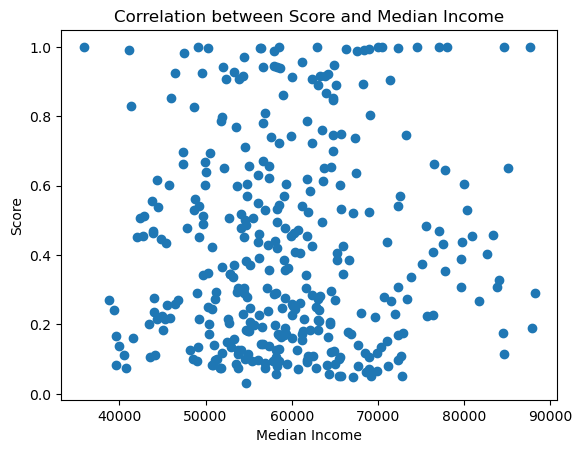

In [41]:
final_scores = query(conn,'SELECT * FROM finalscoreupdated')
income = query(conn,'SELECT * FROM income')
merged_df = pd.merge(final_scores, income, left_on='sa2_code', right_on='sa2_code21')
correlation = merged_df['score'].corr(merged_df['median_income'])

print(f"Correlation between score and median income: {correlation}")

import matplotlib.pyplot as plt

plt.scatter(merged_df['median_income'], merged_df['score'])
plt.xlabel('Median Income')
plt.ylabel('Score')
plt.title('Correlation between Score and Median Income')
plt.show()